In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader,  WeightedRandomSampler
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import torch.nn as nn               
import torch.nn.functional as F  
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.datasets import fetch_openml
import torch.optim as optim 
import matplotlib.pyplot as plt

In [2]:
def create_unified_test_split(
    data: pd.DataFrame,
    test_size: float = 0.2,
    random_state: int = 42,
    save_path: str = "unified_test_set.csv"
):
    """
    Splits the data into train and unified test set and saves the test set to CSV.

    Parameters
    ----------
    data : pd.DataFrame
        The full dataset including features and target.
    test_size : float
        Fraction of the dataset to reserve as the test set.
    random_state : int
        Random seed to make split reproducible.
    save_path : str
        Path where the unified test set CSV will be saved.

    Returns
    -------
    train_data : pd.DataFrame
        The training set (remaining after test split).
    test_data : pd.DataFrame
        The test set saved to `save_path`.
    """
    train_data, test_data = train_test_split(
        data, test_size=test_size, random_state=random_state, shuffle=True
    )

    test_data.to_csv(save_path, index=False)
    print(f"Unified test set saved to '{save_path}' ({len(test_data)} rows).")

    return train_data, test_data


In [23]:
def data_preparation(df):
    y = df['target']
    X = df.drop('target', axis=1)

    # Zielspalte zu numerischen Werten
    y = y.replace({'False': 0, 'True': 1, False: 0, True: 1})

    # Features zu float32 umwandeln und direkt in NumPy konvertieren
    X = X.astype('float32')
    y = y

    return X, y




def get_subtrain_splits(X, y, percentages):

    splits = {}
    for p in percentages:
        X_sub, _, y_sub, _ = train_test_split(
            X, y,
            train_size=p,       
            stratify=y,         
            random_state=42    
        )
        splits[p] = (X_sub, y_sub)
    return splits






class FeatureEngineerer(BaseEstimator, TransformerMixin):


    def __init__(self):
        self.freq_dicts = {}

    def fit(self, X, y=None):
        # Berechne Frequenzen pro Spalte nur einmal
        for col in X.columns:
            self.freq_dicts[col] = X[col].value_counts()
        return self

    def transform(self, X, y=None):
        X_transformed = X.copy()
        features = X.columns
        
        # Liste zur Speicherung der neuen Spalten
        new_features = {}

        for col in features:
            
            # Flag erstellen ob der Wert einzigartig ist
            flag = (X[col].map(self.freq_dicts[col]).fillna(0) <= 1).astype(int)
            new_features[f'flag_is_unique_{col}'] = flag
            
        
        # Füge alle Flags in einem Schritt hinzu
        X_transformed = pd.concat([X_transformed, pd.DataFrame(new_features)], axis=1)

        return X_transformed


class TargetTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, target_col='target'):
        self.target_col = target_col
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        y = X[self.target_col].replace({'False': 0, 'True': 1}).astype(int)
        X = X.drop(columns=[self.target_col])
        return X, y
    


data_pipe = Pipeline([
    ('feature_engineering', FeatureEngineerer()),  # dein Transformer
    ('scaler', StandardScaler())                   # StandardScaler
])


In [28]:
def create_dataloaders_numeric(x_train, y_train, batch_size=32, val_size = 0.2):

    x_train_sample, x_val, y_train_sample, y_val = train_test_split(x_train, y_train, test_size= val_size, random_state=42, stratify=y_train)

    # Daten in PyTorch-Tensoren konvertieren
    X_train_tensor = torch.tensor(x_train_sample.to_numpy(), dtype=torch.float32) #x_train_sample.values
    y_train_tensor = torch.tensor(y_train_sample.to_numpy(), dtype=torch.float32)#y_train_sample.values
    X_val_tensor   = torch.tensor(x_val.to_numpy(), dtype=torch.float32)
    y_val_tensor   = torch.tensor(y_val.to_numpy(), dtype=torch.float32)

    
    # Sicherstellen, dass die Labels die richtige Dimension für die BCELoss haben
    if y_train_tensor.ndim == 1:
        y_train_tensor = y_train_tensor.unsqueeze(1)
    if y_val_tensor.ndim == 1:
        y_val_tensor = y_val_tensor.unsqueeze(1)

    # Datasets erstellen
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    


    # WeightedRandomSampler für ausgeglichene Klassen in  Training- Batches
    class_counts = torch.bincount(y_train_tensor.squeeze().long())
    class_weights = 1. / class_counts.float()
    sample_weights = class_weights[y_train_tensor.squeeze().long()]
    sampler = WeightedRandomSampler(weights=sample_weights,
                                    num_samples=len(sample_weights),
                                    replacement=True)

    # Dataloader 
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler = sampler)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

In [10]:
class FeatureEngineerer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.freq_dicts = {}

    def fit(self, X, y=None):
        for col in X.columns:
            self.freq_dicts[col] = X[col].value_counts()
        return self

    def transform(self, X, y=None):
        X_transformed = X.copy()
        new_features = {}
        for col in X.columns:
            flag = (X[col].map(self.freq_dicts[col]).fillna(0) <= 1).astype(int)
            new_features[f'flag_is_unique_{col}'] = flag
        X_transformed = pd.concat([X_transformed, pd.DataFrame(new_features)], axis=1)
        return X_transformed




def make_pipeline_standardscaler(X, y=None):
    pipe = Pipeline([
        ('feature_engineering', FeatureEngineerer()),
        ('scaler', StandardScaler())
    ])
    return pipe


def make_pipeline_pca_standardscaler(X, y = None, components= 50):
    pipe = Pipeline([
        ('feature_engineering', FeatureEngineerer()),
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components= components))
    ])
    return pipe


In [11]:
def get_prediction(model, loader, device, threshold=0.5):

    # Evaluierungsmodus
    model.eval() 

    # Klassenvorhersage
    pred_labels =[]

    # Tatsächliche Labels
    true_labels = []

    # geschätzte Wahrscheinlichkeiten für prognostizierte Klasse
    pred_probas = []

    # Deaktiviert die Gradientenberechnung weil das nur bei Backpropagation gebraucht wird
    with torch.no_grad(): 
        for X_batch, y_batch in loader:

            # Daten ggf auf GPU verschieben
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            # Vorhersage
            scores = model(X_batch)

            # Vorhersage in Liste speichern
            pred_probas += scores.tolist()

            # Wahre Labels in Liste speichern
            true_labels += y_batch.tolist()

            # Binäre Klassenvorhersage basierend auf dem Schwellenwert
            preds = (scores >= threshold).long()

            # Vorhersagen in Liste speichern
            pred_labels += preds.tolist()

        # zurück in Trainingmodus wechseln
        model.train()

        return np.array(true_labels), np.array(pred_labels), np.array(pred_probas)




def evaluate_model( true_labels, pred_labels, pred_probs):
        
        # Metriken berechnen
        accuracy = accuracy_score(true_labels, pred_labels)
        precision = precision_score(true_labels, pred_labels, zero_division=0)
        recall = recall_score(true_labels, pred_labels, zero_division=0)
        roc_auc = roc_auc_score(true_labels, pred_probs)

        return accuracy, precision, recall, roc_auc

In [33]:
def train_model(model, train_loader, val_loader, loss_fn, optimizer, device, epochs=10, threshold=0.5, patience = 5, min_delta = 0.0):

    # auf Gerät verschieben (CPU oder GPU)
    model = model.to(device)

    # Listen zum Speichern der Metriken
    train_losses = []
    val_accuracies = []
    val_precisions = []
    val_recalls = []
    val_roc_aucs = []

    # Early Stopping Variablen
    best_val_loss = float('inf')  # kleinster Validierungs-Loss bisher
    counter = 0  # wie viele Epochen ohne Verbesserung
    early_stop = False

    # Ausgabe während des Trainings
    print()
    print(f"Metriken des Trainings von Model: {type(model)}")

    # Über Epochen iterieren
    for epoch in range(epochs):

        if early_stop:
            print(f"Early stopping nach {epoch} Epochen")
            break

        # In Trainingsmodus setzen
        model.train()

        # Über Mini-Batches iterieren
        running_loss = 0
        for data, target in train_loader:

            # Daten auf Gerät verschieben
            data, target = data.to(device), target.to(device)

            # Forward
            scores = model(data)

            # Backward und Optimierung
            optimizer.zero_grad() # Gradienten zurücksetzen
            loss = loss_fn(scores, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * data.size(0)

        # In Evaluierungsmodus wechseln
        model.eval()

        
        with torch.no_grad():  
            # Evalusierung mit Validierungsdaten nach jeder Epoche
            true_labels, pred_labels, pred_probs = get_prediction(model,val_loader, device, threshold = threshold)
            accuracy, precision, recall, roc_auc = evaluate_model(true_labels, pred_labels, pred_probs)
         
            print(f"Epoch {epoch + 1}: ROC = {roc_auc:.4f}, Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}")   
          
        

        # Metriken speichern
        val_accuracies.append(accuracy)
        val_precisions.append(precision)
        val_recalls.append(recall)
        val_roc_aucs.append(roc_auc)

        # Duechshcnittlichen loss der Epoche berehcnen
        epoch_loss = running_loss / len(train_loader.dataset)
        # Zu Liste hinzufügen
        train_losses.append(epoch_loss)


        # Early Stopping auf Basis des Validierungs-Loss
        if epoch_loss < best_val_loss - min_delta:
            best_val_loss = epoch_loss
            counter = 0  # Verbesserung → Counter zurücksetzen
        else:
            counter += 1
            if counter >= patience:
                early_stop = True



    # leere zeile für übersichtliche Ausgabe während des trainings
    print()    

    metrics = {
        'train_losses': train_losses,
        'val_accuracies': val_accuracies,
        'val_precisions': val_precisions,
        'val_recalls': val_recalls,
        'val_roc_aucs': val_roc_aucs
    }

    return metrics

In [13]:
class NN_1(nn.Module):

    def __init__(self, feature_n, hidden_dim1, hidden_dim2, hidden_dim3):

        #Konstruktor der Elternklasse aufrufen
        super(NN_1, self).__init__()

        # Normalisierungsschicht 
        self.bn = nn.BatchNorm1d(feature_n)

        # fully connected layer 
        # soll immer ein orginal feature mit dem dazugehrigen Feature verarebiten das angibt ob der Wert einzigartig ist
        self.fc1 = nn.Linear(2, hidden_dim1) # Parallele Verarbeitung

         # Zusätzliche hidden-layers  für die globale Verarbeitung
        self.fc2 = nn.Linear(200 * hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)

        # Ausgabe layer
        self.ol = nn.Linear(hidden_dim3, 1) 

        self.sigmoid = nn.Sigmoid()






    def forward(self, x):

        # Sample size 
        N = x.shape[0]

        # Batch Normalisierung
        x = self.bn(x)
 

        # Aufteilen der Originalfeatures und der engineerten Features
        # Dimensionen: [batch_size, 200, 1] 
        x_orig = x[: , :200]
        x_engineered = x[:, 200:]

        # Dimensionen anpassen für das zusammenfügen
        x_orig = x_orig.unsqueeze(2)
        x_engineered = x_engineered.unsqueeze(2)

        # jetzt zusammenfügen in [batch_size, 200, 2]
        x = torch.cat([x_orig, x_engineered], dim=2)

        # Parallele Verarbeitung der Feature Paare in erster fully connected layer 
        x = F.relu(self.fc1(x))

        # reshape  um erwartete 2 Dimensionen zu erhalten
        x = x.view(N, -1)

        # Zusätzliche fully connected layer für die globale Mustererkennung
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        # Ausgabe layer
        x = self.ol(x)

        #  Sigmoid Aktivierungsfunktion und reshape zu [batch_size]
        x = self.sigmoid(x)

        return x
    

In [14]:
# FUnktion zum Ergebnisse visualiseren
def plot_metrics(metrics):

    epochs = range(1, len(metrics['train_losses']) + 1)

    plt.figure(figsize=(15, 10))

    # Plot des Trainingsverlusts
    plt.subplot(2, 1, 1)
    plt.plot(epochs, metrics['train_losses'], 'b-o', label='Trainingsverlust')
    plt.title('Trainingsverlauf: Verlust pro Epoche')
    plt.xlabel('Epoche')
    plt.ylabel('Verlust')
    plt.legend()
    plt.grid(True)

    # Plot der Validierungsmetriken
    plt.subplot(2, 1, 2)
    plt.plot(epochs, metrics['val_accuracies'], 'r-o', label='Validierungs-Genauigkeit')
    plt.plot(epochs, metrics['val_precisions'], 'g-o', label='Validierungs-Präzision')
    plt.plot(epochs, metrics['val_recalls'], 'c-o', label='Validierungs-Recall')
    plt.plot(epochs, metrics['val_roc_aucs'], 'm-o', label='Validierungs-ROC AUC')
    plt.title('Validierungsmetriken pro Epoche')
    plt.xlabel('Epoche')
    plt.ylabel('Wert')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
# Daten laden 

dataset = fetch_openml(data_id=45566, as_frame=True)

# Einheitlichen Testsplit machen
data_train_and_val, data_test = create_unified_test_split(st)

# Erneuter Split für Validierungsdaten
data_train, data_val = create_unified_test_split(data_train_and_val) 

st = dataset.frame

In [29]:

 
# Daten in float32 umwandlen und target trennen und in 0 und 1 -kategorie
# x_train, y_train = data_preparation(data_train)
x_train, y_train = data_preparation(data_train)
x_val, y_val = data_preparation(data_val)
x_test, y_test = data_preparation(data_test)   

# Feature engineering
fe = FeatureEngineerer()
x_train = fe.fit_transform(x_train)
x_val = fe.transform(x_val)
x_test = fe.transform(x_test)

# Trainingsdaten in versch. große Subdataframes teilen für trianings und Modellauswahl
percentages = [0.1, 0.2, 0.3, 0.4, 0.6, 0.8]
splits = get_subtrain_splits(x_train, y_train, percentages)
X_sub_10, y_sub_10 = splits[0.1]
X_sub_20, y_sub_20 = splits[0.2]
X_sub_30, y_sub_30 = splits[0.3]
X_sub_40, y_sub_40 = splits[0.4]
X_sub_60, y_sub_60 = splits[0.6]
X_sub_80, y_sub_80 = splits[0.8]

# Seed für torch setzen
torch.manual_seed(42)

C:\Users\hbrem\AppData\Local\Temp\ipykernel_20528\3474261255.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace({'False': 0, 'True': 1, False: 0, True: 1})
C:\Users\hbrem\AppData\Local\Temp\ipykernel_20528\3474261255.py:6: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  y = y.replace({'False': 0, 'True': 1, False: 0, True: 1})
C:\Users\hbrem\AppData\Local\Temp\ipykernel_20528\3474261255.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly c


Metriken des Trainings von Model: <class '__main__.NN_1'>
Epoch 1: ROC = 0.8629, Accuracy = 0.7004, Precision = 0.2298, Recall = 0.8490
Epoch 2: ROC = 0.8464, Accuracy = 0.7900, Precision = 0.2867, Recall = 0.7396
Epoch 3: ROC = 0.8281, Accuracy = 0.7495, Precision = 0.2498, Recall = 0.7513
Epoch 4: ROC = 0.8403, Accuracy = 0.8333, Precision = 0.3329, Recall = 0.6641



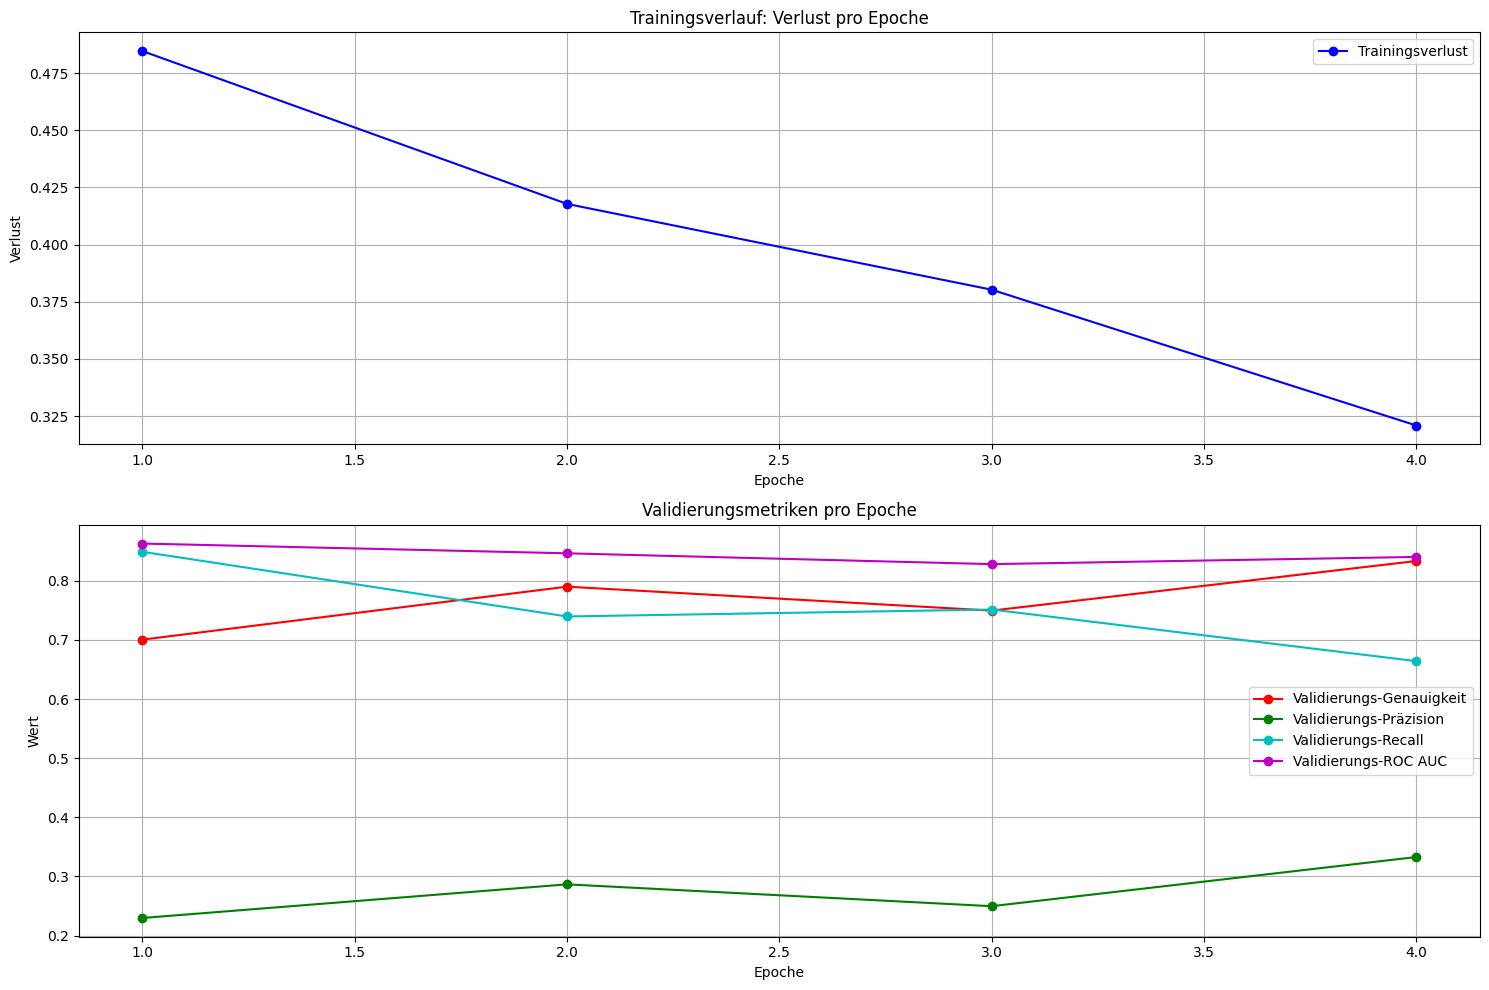

In [34]:
#########################################
##### ertsets trianing mit 30% der Daten
#########################################

# Daten mit Dataloader vorbereiten
train_loader_30, val_loader_30 = create_dataloaders_numeric(X_sub_30, y_sub_30, 32, val_size = 0.2)

print(f'Training mit {X_sub_30.shape[0]} Samples')

# Modell Parmater festlegen
feature_n = X_sub_30.shape[1]
hidden_dim1 = 300
hidden_dim2 = 200
hidden_dim3 = 70

# Device automatisch anpassen wenn GPU verfügbar 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Modell Objekt erstellen
nn1 = NN_1(feature_n, hidden_dim1, hidden_dim2, hidden_dim3)
nn1.to(device)

# parameter fürs training festlegen
epochs = 4
learning_rate = 0.001
loss_fn = nn.BCELoss() # Binary Class Entropy
optimizer = optim.Adam(nn1.parameters(), lr= learning_rate) #Adam optimizer 

# Seed für torch setzen
torch.manual_seed(42)

# Training starten
metrics = train_model(nn1, train_loader_30, val_loader_30,loss_fn, optimizer,device= device, epochs = epochs,patience= 5, min_delta= 0.001)

# Logitische Regression zum vergelich anwenden
#regmetrics =  run_logistic_regression_baseline(X_sub_30, y_sub_30, val_size= 0.2)


# Ergebnisse visualsieren
plot_metrics(metrics)
